In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import numpy as np
import pandas as pd

from dice_rl_TU_Vienna.value import get_w_prod, get_get_policy_value
from dice_rl_TU_Vienna.plot.general import plot_histogram

from dice_rl_TU_Vienna.utils.seeds import set_all_seeds

In [3]:
dir_base = os.path.join("data", "medical_rl", "sepsis_mimic_iv")

In [4]:
split = pd.read_parquet( os.path.join(dir_base, "split.parquet") )

In [5]:
n_obs = split["state"] .max() + 1
n_act = split["action"].max() + 1

n_obs, n_act

(752, 25)

In [7]:
def get_dataset(split, padding=False, seed=None):
    set_all_seeds(seed)

    path = os.path.join(dir_base, "dataset.parquet")
    if os.path.exists(path): return pd.read_parquet(path)

    dataset = {
        "id": [],
        "t": [],
        "obs_init": [],
        "obs": [],
        "act": [],
        "rew": [],
        "obs_next": [],
        "probs_init": [],
        "probs_next": [],
        "probs": [],
        "probs_behavior": [],
    }

    for i in range(len(split)):
        id = split.loc[i, "icustayid"]
        t  = split.loc[i, "bloc"] - 1 # type: ignore

        if i == 0 or split.loc[i-1, "icustayid"] != id:
            obs_init   = split.loc[i, "state"]
            probs_init = split.loc[i, "model_probs"][:-1]

        if i == len(split) - 1 or split.loc[i+1, "icustayid"] != id:
            if not padding: continue

            obs = split.loc[i, "state"]
            act = np.random.choice(n_act, p=split.loc[i, "phys_probs"][:-1])
            rew = 0
            obs_next = obs

            probs          = split.loc[i, "model_probs"][:-1]
            probs_behavior = split.loc[i, "phys_probs"][:-1]
            probs_next = probs

        else:
            obs      = split.loc[i, "state"]
            act      = split.loc[i, "action"]
            rew      = split.loc[i+1, "reward"]
            obs_next = split.loc[i+1, "state"]

            probs          = split.loc[i, "model_probs"][:-1]
            probs_behavior = split.loc[i, "phys_probs"][:-1]
            probs_next     = split.loc[i+1, "model_probs"][:-1]

        dataset["id"].append(id)
        dataset["t"] .append(t)

        dataset["obs_init"].append(obs_init)
        dataset["obs"]     .append(obs)
        dataset["act"]     .append(act)
        dataset["rew"]     .append(rew)
        dataset["obs_next"].append(obs_next)

        dataset["probs_init"]    .append(probs_init)
        dataset["probs"]         .append(probs)
        dataset["probs_behavior"].append(probs_behavior)
        dataset["probs_next"]    .append(probs_next)

    dataset = pd.DataFrame(dataset)
    dataset.to_parquet(path)

    return dataset

In [8]:
dataset = get_dataset(split, padding=True, seed=0)

In [9]:
split.head(17)

,bloc,icustayid,state,action,outcome,reward,model_probs,phys_probs,action_idx
0,1,30000484,438,0,1,0,"[0.0004166666666666667, 0.0004166666666666667,...","[0.7561417322834645, 0.0004761904761904762, 0....",0
1,2,30000484,152,20,1,0,"[0.0004166666666666667, 0.0004166666666666667,...","[0.9125, 0.0004761904761904762, 0.000476190476...",0
2,3,30000484,687,20,1,0,"[0.0004166666666666667, 0.0004166666666666667,...","[0.08056338028169015, 0.0008333333333333335, 0...",20
3,4,30000484,687,20,1,0,"[0.0004166666666666667, 0.0004166666666666667,...","[0.08056338028169015, 0.0008333333333333335, 0...",20
4,5,30000484,732,16,1,0,"[0.0004166666666666667, 0.0004166666666666667,...","[0.058563380281690135, 0.0016666666666666668, ...",20
5,6,30000484,610,11,1,0,"[0.0004166666666666667, 0.0004166666666666667,...","[0.05538461538461537, 0.0012499999999999998, 0...",16
6,7,30000484,132,11,1,0,"[0.0004166666666666667, 0.0004166666666666667,...","[0.07031250000000001, 0.0007692307692307693, 0...",11
7,8,30000484,428,16,1,0,"[0.0004166666666666667, 0.0004166666666666667,...","[0.07946938775510204, 0.0016666666666666668, 0...",11
8,9,30000484,542,1,1,0,"[0.0004166666666666667, 0.0004166666666666667,...","[0.05634146341463414, 0.0009090909090909091, 0...",16
9,10,30000484,518,1,1,0,"[0.0004166666666666667, 0.0004166666666666667,...","[0.8084527220630374, 0.0005000000000000001, 0....",1


In [15]:
dataset.head(16)

,id,t,obs_init,obs,act,rew,obs_next,probs_init,probs_next,probs,probs_behavior
0,30000484,0,438,438,0,0,152,"[0.0004166666666666667, 0.0004166666666666667,...","[0.0004166666666666667, 0.0004166666666666667,...","[0.0004166666666666667, 0.0004166666666666667,...","[0.7561417322834645, 0.0004761904761904762, 0...."
1,30000484,1,438,152,20,0,687,"[0.0004166666666666667, 0.0004166666666666667,...","[0.0004166666666666667, 0.0004166666666666667,...","[0.0004166666666666667, 0.0004166666666666667,...","[0.9125, 0.0004761904761904762, 0.000476190476..."
2,30000484,2,438,687,20,0,687,"[0.0004166666666666667, 0.0004166666666666667,...","[0.0004166666666666667, 0.0004166666666666667,...","[0.0004166666666666667, 0.0004166666666666667,...","[0.08056338028169015, 0.0008333333333333335, 0..."
3,30000484,3,438,687,20,0,732,"[0.0004166666666666667, 0.0004166666666666667,...","[0.0004166666666666667, 0.0004166666666666667,...","[0.0004166666666666667, 0.0004166666666666667,...","[0.08056338028169015, 0.0008333333333333335, 0..."
4,30000484,4,438,732,16,0,610,"[0.0004166666666666667, 0.0004166666666666667,...","[0.0004166666666666667, 0.0004166666666666667,...","[0.0004166666666666667, 0.0004166666666666667,...","[0.058563380281690135, 0.0016666666666666668, ..."
5,30000484,5,438,610,11,0,132,"[0.0004166666666666667, 0.0004166666666666667,...","[0.0004166666666666667, 0.0004166666666666667,...","[0.0004166666666666667, 0.0004166666666666667,...","[0.05538461538461537, 0.0012499999999999998, 0..."
6,30000484,6,438,132,11,0,428,"[0.0004166666666666667, 0.0004166666666666667,...","[0.0004166666666666667, 0.0004166666666666667,...","[0.0004166666666666667, 0.0004166666666666667,...","[0.07031250000000001, 0.0007692307692307693, 0..."
7,30000484,7,438,428,16,0,542,"[0.0004166666666666667, 0.0004166666666666667,...","[0.0004166666666666667, 0.0004166666666666667,...","[0.0004166666666666667, 0.0004166666666666667,...","[0.07946938775510204, 0.0016666666666666668, 0..."
8,30000484,8,438,542,1,0,518,"[0.0004166666666666667, 0.0004166666666666667,...","[0.0004166666666666667, 0.0004166666666666667,...","[0.0004166666666666667, 0.0004166666666666667,...","[0.05634146341463414, 0.0009090909090909091, 0..."
9,30000484,9,438,518,1,0,518,"[0.0004166666666666667, 0.0004166666666666667,...","[0.0004166666666666667, 0.0004166666666666667,...","[0.0004166666666666667, 0.0004166666666666667,...","[0.8084527220630374, 0.0005000000000000001, 0...."


In [16]:
from dice_rl_TU_Vienna.estimators.tabular.tabular_dice import TabularDice

In [17]:
n_obs = max(dataset["obs_init"].max(), dataset["obs"].max(), dataset["obs_next"].max()) + 1
n_act = dataset["act"].max() + 1

In [18]:
n_obs, n_act

(752, 25)

In [21]:
tabular_dice = TabularDice(dataset, n_obs, n_act, dir_base, verbosity=1)

trying to load auxiliary estimates from data/medical_rl/sepsis_mimic_iv
failed to load
creating auxiliary estimates from dataset


100%|██████████| 145142/145142 [11:23<00:00, 212.30it/s]


saving auxiliary estimates
saved data/medical_rl/sepsis_mimic_iv/d0_bar.npy
saved data/medical_rl/sepsis_mimic_iv/dD_bar.npy
saved data/medical_rl/sepsis_mimic_iv/P_bar.npy
saved data/medical_rl/sepsis_mimic_iv/r_bar.npy
saved data/medical_rl/sepsis_mimic_iv/n.npy


In [22]:
from dice_rl_TU_Vienna.value import get_get_policy_value

In [23]:
dataset

,id,t,obs_init,obs,act,rew,obs_next,probs_init,probs_next,probs,probs_behavior
0,30000484,0,438,438,0,0,152,"[0.0004166666666666667, 0.0004166666666666667,...","[0.0004166666666666667, 0.0004166666666666667,...","[0.0004166666666666667, 0.0004166666666666667,...","[0.7561417322834645, 0.0004761904761904762, 0...."
1,30000484,1,438,152,20,0,687,"[0.0004166666666666667, 0.0004166666666666667,...","[0.0004166666666666667, 0.0004166666666666667,...","[0.0004166666666666667, 0.0004166666666666667,...","[0.9125, 0.0004761904761904762, 0.000476190476..."
2,30000484,2,438,687,20,0,687,"[0.0004166666666666667, 0.0004166666666666667,...","[0.0004166666666666667, 0.0004166666666666667,...","[0.0004166666666666667, 0.0004166666666666667,...","[0.08056338028169015, 0.0008333333333333335, 0..."
3,30000484,3,438,687,20,0,732,"[0.0004166666666666667, 0.0004166666666666667,...","[0.0004166666666666667, 0.0004166666666666667,...","[0.0004166666666666667, 0.0004166666666666667,...","[0.08056338028169015, 0.0008333333333333335, 0..."
4,30000484,4,438,732,16,0,610,"[0.0004166666666666667, 0.0004166666666666667,...","[0.0004166666666666667, 0.0004166666666666667,...","[0.0004166666666666667, 0.0004166666666666667,...","[0.058563380281690135, 0.0016666666666666668, ..."
...,...,...,...,...,...,...,...,...,...,...,...
145137,39999172,7,673,363,20,0,363,"[0.99, 0.0004166666666666667, 0.00041666666666...","[0.0004166666666666667, 0.0004166666666666667,...","[0.0004166666666666667, 0.0004166666666666667,...","[0.05361460957178842, 0.0011111111111111113, 0..."
145138,39999172,8,673,363,0,0,505,"[0.99, 0.0004166666666666667, 0.00041666666666...","[0.0004166666666666667, 0.0004166666666666667,...","[0.0004166666666666667, 0.0004166666666666667,...","[0.05361460957178842, 0.0011111111111111113, 0..."
145139,39999172,9,673,505,0,0,651,"[0.99, 0.0004166666666666667, 0.00041666666666...","[0.0004166666666666667, 0.0004166666666666667,...","[0.0004166666666666667, 0.0004166666666666667,...","[0.6817924528301886, 0.0004761904761904762, 0...."
145140,39999172,10,673,651,0,100,751,"[0.99, 0.0004166666666666667, 0.00041666666666...","[0.0004166666666666667, 0.0004166666666666667,...","[0.0004166666666666667, 0.0004166666666666667,...","[0.9618292682926829, 0.0004347826086956522, 0...."


In [24]:
IS_weights = dataset.apply(lambda x: x["probs"][ x["act"] ] / x["probs_behavior"][ x["act"] ], axis=1)
IS_weights_prod = get_w_prod(dataset, IS_weights)

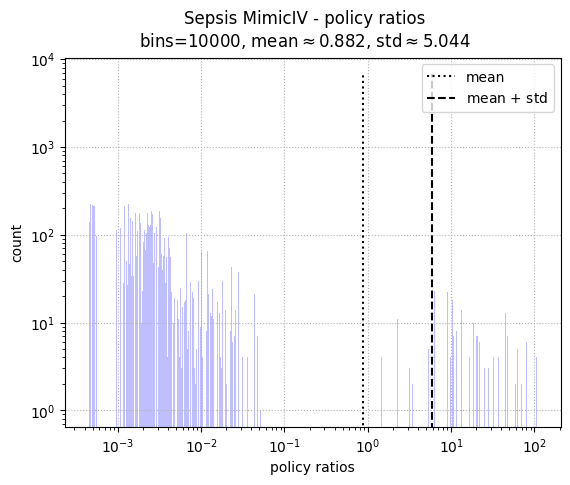

In [69]:
plot_histogram(
    data=IS_weights, bins=10_000, moving_average_radius=None,
    suptitle="Sepsis MimicIV - policy ratios", xlabel="policy ratios",
    xscale=True, yscale=True,
)

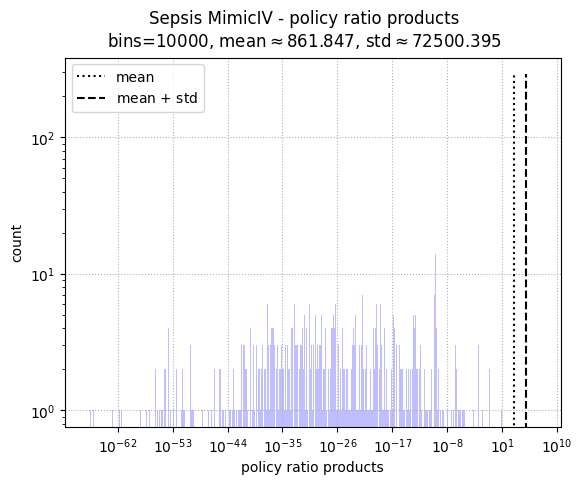

In [70]:
plot_histogram(
    data=IS_weights_prod, bins=10_000,
    suptitle="Sepsis MimicIV - policy ratio products", xlabel="policy ratio products",
    xscale=True, yscale=True,
)

In [40]:
estimators_OnPE = {
    "behavior": get_get_policy_value(dataset),
}

f = get_get_policy_value(dataset, IS_weights)
g = lambda gamma, scale=True: f(gamma, scale, weighted=False)
g.__name__ = "SIS"
h = lambda gamma, scale=True: f(gamma, scale, weighted=True)
h.__name__ = "WIS"

estimators_IS = { False: g, True: h, }

In [46]:
for gamma in [0.9, 0.99, 0.999, 0.9999]:

    print(f"{gamma=}")

    print( estimators_OnPE["behavior"](gamma, scale=False) )
    print( estimators_IS  [False]     (gamma, scale=False) )
    print( estimators_IS  [True]      (gamma, scale=False) )

    print( tabular_dice.solve(gamma, projected=True, modified=True, weighted=False)[0] / (1 - gamma) )
    print( tabular_dice.solve(gamma, projected=True, modified=True, weighted=True) [0] / (1 - gamma) )

    print()

gamma=0.9
20.370635153239355
38315.26294703724
44.45717297213193
22.35481900401235
19.554597718745395

gamma=0.99
45.93737936451142
74669.30369609054
86.6387411907984
44.49640119231621
34.41377728151037

gamma=0.999
50.09365881328027
79568.61626566242
92.32341016073534
51.53521275142462
37.87437958121215

gamma=0.9999
50.53181709769514
80073.36448490368
92.90906916877093
52.70827014773759
38.35924196268011



In [ ]:
print( estimators_OnPE["behavior"](gamma=1.0, scale=False) )
print( estimators_IS  [False]     (gamma=1.0, scale=False) )
print( estimators_IS  [True]      (gamma=1.0, scale=False) )

50.580763767025985
80129.61653253937
92.97433838055301


In [75]:
dataset.rew.sum() / dataset.id.unique().size

50.580763767025985

In [178]:
from datetime import datetime

datetime.now().isoformat()

'2025-02-13T18:37:28.523273'